## Author: Alexandru Paul Tabacaru  ;  alextabac@gmail.com
## MIT License

In [26]:
import pandas as pd
import numpy as np
from math import floor
import scipy.stats as stats
import os
import json
import random
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from datetime import datetime
from collections import deque
from MASS_V4 import MASS_V4
from DAMP_V2 import DAMP_V2
from datetime import datetime
import matplotlib.pyplot as plt
from importlib import reload

## Paths and Data Files

In [3]:
os.getcwd()

'C:\\ALEX\\BGU\\TDA\\PROJECT\\TSAD_project'

In [4]:
data_path = "..\\..\\sensors_data"
data_folder = os.path.join(os.getcwd(), data_path)
files1 = os.listdir(data_folder)
files2 = [os.path.join(data_folder, f) for f in files1 if f.endswith("_trim.tab")]
files = [f for f in files2 if os.path.isfile(f)]
delimiter = "\t"

In [5]:
files

['C:\\ALEX\\BGU\\TDA\\PROJECT\\TSAD_project\\..\\..\\sensors_data\\fdc_F28_PROD_XEUS_trim.tab']

## Equipment digits explained:
### first digit is the XEUS NOD number:  1, 2, 3, or 4 otherwise
### second digit is the SITE within the NOD: 0, 1, 2.
### third digit is the entity number: 0 to 6 at most
### fourth digit is the side of the entity:  0 or 1

In [103]:
class Data_Preprocess:
    """
    Raw data is aggregated over 1hr time window, and each 1hr will be represented by mean/std-dev.
    """
    
    def __init__(self):
        self.df = None
        self.dfs = []
        
    def load_data(self, filename, delimiter):
        df = pd.read_csv(filename, delimiter=delimiter)
        print(f"File loaded with {len(df)} rows.")
        all_cols = True
        needed_cols = ['RUN_START_DATE', 'Equip', 'Feature', 'PREP_VALUE']
        cols = list(df.columns)
        miss_cols = []
        for col in needed_cols:
            if col not in cols:
                all_cols = False
                miss_cols.append(col)
        if len(miss_cols) > 0:
            print("Cound not find the following columns: " + ",".join(miss_cols))
        if all_cols:
            df['RUN_START_DATE'] = pd.to_datetime(df['RUN_START_DATE'])
            df = df.sort_values('RUN_START_DATE')
            df.insert(0, 'time', df['RUN_START_DATE'].dt.floor('H'))
            df['mean'] = df.groupby(['Equip', 'Feature'], as_index=False)['PREP_VALUE'].transform('mean')
            df['std'] = df.groupby(['Equip', 'Feature'], as_index=False)['PREP_VALUE'].transform('std')
            df['norm'] = (df['PREP_VALUE'] - df['mean']) / df['std']
            df = df.drop(['PREP_VALUE', 'mean', 'std'], axis=1)
            df = df.groupby(['time', 'RUN_START_WW', 'Equip', 'Feature'], as_index=False)['norm'].\
             agg(['mean', 'std']).reset_index().fillna(0)
            df = df.melt(id_vars=['time', 'RUN_START_WW', 'Equip', 'Feature'], value_vars=['mean', 'std'])
            df['series'] = df['Feature'] + "_" + df['variable']
            df = df.drop(['Feature', 'variable'], axis=1)
            self.df = df
    
    def prepare_series(self):
        s_time = datetime.now()
        self.df['key'] = self.df['Equip'] + "_" + self.df['series']
        uniq_keys = self.df['key'].unique()
        dfs = []
        for ukey in uniq_keys:
            print(f"Preparing key series {ukey} ...")
            ddf = self.df[self.df['key'] == ukey]
            ddf = ddf.sort_values(by=['series', 'Equip', 'time'], ascending=[True, True, True])
            ddf = ddf.reset_index(drop=True)
            ddf_list = []
            self.recur_split_series_no_multi_clusters(ukey, ddf, ddf_list, ave_size=20, threshold=1.8)
            for ddfl in ddf_list:
                ddfl = ddfl.sort_values(by=['series', 'Equip', 'time'], ascending=[True, True, True])
                ddfl = ddfl.reset_index(drop=True)
                m = np.mean(ddfl['value'])
                s = np.std(ddfl['value'])
                ddfl['norm'] = (ddfl['value'] - m) / s
                ddfl = ddfl.drop(['value'], axis=1)
                dfs.append(ddfl)
        self.dfs = dfs
        e_time = datetime.now()
        d_time = e_time - s_time
        print(f"Data preparation run time {d_time}")
    
    def recur_split_series_no_multi_clusters(self, ukey, df, ddf_list, ave_size=10, threshold=1.5):
        delta, indx = self.get_series_split_max_distance(df, ave_size=ave_size)
        if delta > threshold:
            print(f"Found two clusters or more and need split, in dataset {ukey}, indx {indx}, delta {delta}.")
            self.recur_split_series_no_multi_clusters(ukey, df[indx:], ddf_list, ave_size, threshold)
            self.recur_split_series_no_multi_clusters(ukey, df[:indx], ddf_list, ave_size, threshold)
        ddf_list.append(df)
        
    def get_series_split_max_distance(self, df, ave_size=10):
        delta = 0
        ki = 0
        for i in range(ave_size, len(df) - ave_size):
            k1 = np.mean(df[(i-ave_size+1):i]['value'].values)
            k2 = np.mean(df[i:(i+ave_size-1)]['value'].values)
            d = abs(k1 - k2)
            if d > delta:
                delta = d
                ki = i
        return delta, ki

In [7]:
data_obj = Data_Preprocess()
data_obj.load_data(files[0], delimiter)

File loaded with 11568827 rows.


In [8]:
len(data_obj.df)

892868

In [9]:
data_obj.prepare_series()

Preparing key series Equip2000_Feature2_mean ...
Preparing key series Equip2000_Feature5_mean ...
Preparing key series Equip2000_Feature6_mean ...
Preparing key series Equip2000_Feature7_mean ...
Preparing key series Equip2000_Feature8_mean ...
Preparing key series Equip2001_Feature2_mean ...
Preparing key series Equip2001_Feature5_mean ...
Preparing key series Equip2001_Feature6_mean ...
Preparing key series Equip2001_Feature7_mean ...
Preparing key series Equip2001_Feature8_mean ...
Preparing key series Equip2010_Feature0_mean ...
Found two clusters or more and need split, in dataset Equip2010_Feature0_mean, indx 2909, delta 3.273769076852412.
Found two clusters or more and need split, in dataset Equip2010_Feature0_mean, indx 2888, delta 2.4586883267019286.
Preparing key series Equip2010_Feature1_mean ...
Preparing key series Equip2010_Feature2_mean ...
Preparing key series Equip2010_Feature3_mean ...
Found two clusters or more and need split, in dataset Equip2010_Feature3_mean, indx

Preparing key series Equip2001_Feature9_mean ...
Preparing key series Equip2020_Feature0_mean ...
Found two clusters or more and need split, in dataset Equip2020_Feature0_mean, indx 377, delta 4.044147563764092.
Preparing key series Equip2020_Feature1_mean ...
Found two clusters or more and need split, in dataset Equip2020_Feature1_mean, indx 357, delta 6.437874497983519.
Found two clusters or more and need split, in dataset Equip2020_Feature1_mean, indx 20, delta 6.35043766542879.
Preparing key series Equip2020_Feature2_mean ...
Preparing key series Equip2020_Feature3_mean ...
Found two clusters or more and need split, in dataset Equip2020_Feature3_mean, indx 357, delta 6.063637492193319.
Found two clusters or more and need split, in dataset Equip2020_Feature3_mean, indx 37, delta 5.102636636922242.
Preparing key series Equip2020_Feature4_mean ...
Preparing key series Equip2020_Feature5_mean ...
Preparing key series Equip2020_Feature6_mean ...
Preparing key series Equip2020_Feature7_m

Preparing key series Equip2031_Feature4_std ...
Preparing key series Equip2031_Feature9_std ...
Preparing key series Equip2050_Feature0_std ...
Preparing key series Equip2050_Feature1_std ...
Preparing key series Equip2050_Feature2_std ...
Preparing key series Equip2050_Feature3_std ...
Preparing key series Equip2050_Feature4_std ...
Preparing key series Equip2050_Feature5_std ...
Preparing key series Equip2050_Feature6_std ...
Preparing key series Equip2050_Feature7_std ...
Preparing key series Equip2050_Feature8_std ...
Preparing key series Equip2050_Feature9_std ...
Preparing key series Equip2051_Feature0_std ...
Preparing key series Equip2051_Feature1_std ...
Preparing key series Equip2051_Feature2_std ...
Preparing key series Equip2051_Feature3_std ...
Preparing key series Equip2051_Feature4_std ...
Preparing key series Equip2051_Feature5_std ...
Preparing key series Equip2051_Feature6_std ...
Preparing key series Equip2051_Feature7_std ...
Preparing key series Equip2051_Feature8_

In [10]:
len(data_obj.dfs)

420

In [11]:
type(data_obj.dfs)

list

In [12]:
N = 0
for df in data_obj.dfs:
    N += len(df)
print(N)

1071834


In [13]:
np.mean(data_obj.dfs[5])

C:\ProgramData\Anaconda3_64bit\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\ProgramData\Anaconda3_64bit\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


RUN_START_WW    2.022374e+05
norm            5.982616e-17
dtype: float64

In [14]:
np.std(data_obj.dfs[5])

C:\ProgramData\Anaconda3_64bit\lib\site-packages\numpy\core\fromnumeric.py:3558: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


time            43 days 14:42:36.826547264
RUN_START_WW                      6.238579
norm                                   1.0
dtype: object

In [15]:
data_obj.dfs[5].head(5)

,time,RUN_START_WW,Equip,series,key,norm
0,2022-06-26 23:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,2.946667
1,2022-06-27 00:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,1.225551
2,2022-06-27 01:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,0.926174
3,2022-06-27 02:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.380895
4,2022-06-27 03:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.941805


In [16]:
for i in range(20):
    print(data_obj.dfs[i].loc[0, 'key'])

Equip2000_Feature2_mean
Equip2000_Feature5_mean
Equip2000_Feature6_mean
Equip2000_Feature7_mean
Equip2000_Feature8_mean
Equip2001_Feature2_mean
Equip2001_Feature5_mean
Equip2001_Feature6_mean
Equip2001_Feature7_mean
Equip2001_Feature8_mean
Equip2010_Feature0_mean
Equip2010_Feature0_mean
Equip2010_Feature0_mean
Equip2010_Feature0_mean
Equip2010_Feature0_mean
Equip2010_Feature1_mean
Equip2010_Feature2_mean
Equip2010_Feature3_mean
Equip2010_Feature3_mean
Equip2010_Feature3_mean


In [17]:
data_obj.dfs[5]['norm'].mean()

5.982616181790733e-17

In [18]:
data_obj.dfs[5]['norm']

0       2.946667
1       1.225551
2       0.926174
3      -0.380895
4      -0.941805
          ...   
3417   -0.586700
3418    0.526579
3419    0.542681
3420   -0.211703
3421    1.507836
Name: norm, Length: 3422, dtype: float64

In [19]:
data_obj.dfs[5]['norm'] = stats.zscore(data_obj.dfs[5]['norm'])

In [20]:
data_obj.dfs[5]['norm']

0       2.946667
1       1.225551
2       0.926174
3      -0.380895
4      -0.941805
          ...   
3417   -0.586700
3418    0.526579
3419    0.542681
3420   -0.211703
3421    1.507836
Name: norm, Length: 3422, dtype: float64

In [21]:
data_obj.dfs[5]

,time,RUN_START_WW,Equip,series,key,norm
0,2022-06-26 23:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,2.946667
1,2022-06-27 00:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,1.225551
2,2022-06-27 01:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,0.926174
3,2022-06-27 02:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.380895
4,2022-06-27 03:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.941805
...,...,...,...,...,...,...
3417,2022-11-23 22:00:00,202248,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.586700
3418,2022-11-23 23:00:00,202248,Equip2001,Feature2_mean,Equip2001_Feature2_mean,0.526579
3419,2022-11-24 00:00:00,202248,Equip2001,Feature2_mean,Equip2001_Feature2_mean,0.542681
3420,2022-11-24 01:00:00,202248,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.211703


In [39]:
circflow_mean_idx = []
for i in range(len(data_obj.dfs)):
    if 'Feature9' in data_obj.dfs[i].loc[0, 'key'] and len(data_obj.dfs[i]) > 1000:
        circflow_mean_idx.append(i)
        print(f"index {i} - key {data_obj.dfs[i].loc[0, 'key']} - len {len(data_obj.dfs[i])}")

index 28 - key Equip2010_Feature9_mean - len 2891
index 29 - key Equip2010_Feature9_mean - len 3349
index 47 - key Equip2011_Feature9_mean - len 3349
index 54 - key Equip2030_Feature9_mean - len 3395
index 63 - key Equip2031_Feature9_mean - len 3395
index 83 - key Equip2050_Feature9_mean - len 3428
index 97 - key Equip2051_Feature9_mean - len 3428
index 107 - key Equip2060_Feature9_mean - len 2333
index 125 - key Equip2061_Feature9_mean - len 2333
index 138 - key Equip2000_Feature9_mean - len 2930
index 140 - key Equip2000_Feature9_mean - len 3495
index 157 - key Equip2001_Feature9_mean - len 3495
index 177 - key Equip2020_Feature9_mean - len 3006
index 181 - key Equip2020_Feature9_mean - len 3381
index 207 - key Equip2021_Feature9_mean - len 3006
index 209 - key Equip2021_Feature9_mean - len 3381
index 239 - key Equip2040_Feature9_mean - len 2331
index 240 - key Equip2040_Feature9_mean - len 3036
index 253 - key Equip2041_Feature9_mean - len 3036
index 285 - key Equip2010_Feature9_std

In [40]:
circflow_std_idx = []
for i in range(len(data_obj.dfs)):
    if 'Feature4' in data_obj.dfs[i].loc[0, 'key'] and len(data_obj.dfs[i]) > 1000:
        circflow_std_idx.append(i)
        print(f"index {i} - key {data_obj.dfs[i].loc[0, 'key']} - len {len(data_obj.dfs[i])}")

index 20 - key Equip2010_Feature4_mean - len 3349
index 42 - key Equip2011_Feature4_mean - len 3349
index 53 - key Equip2030_Feature4_mean - len 3395
index 62 - key Equip2031_Feature4_mean - len 3395
index 78 - key Equip2050_Feature4_mean - len 3428
index 92 - key Equip2051_Feature4_mean - len 3428
index 102 - key Equip2060_Feature4_mean - len 2333
index 120 - key Equip2061_Feature4_mean - len 2333
index 137 - key Equip2000_Feature4_mean - len 3495
index 156 - key Equip2001_Feature4_mean - len 3495
index 172 - key Equip2020_Feature4_mean - len 3381
index 194 - key Equip2021_Feature4_mean - len 2994
index 198 - key Equip2021_Feature4_mean - len 3381
index 225 - key Equip2040_Feature4_mean - len 3036
index 244 - key Equip2041_Feature4_mean - len 3036
index 280 - key Equip2010_Feature4_std - len 3349
index 294 - key Equip2011_Feature4_std - len 3349
index 307 - key Equip2030_Feature4_std - len 3395
index 316 - key Equip2031_Feature4_std - len 3395
index 322 - key Equip2050_Feature4_std - 

In [41]:
ppress_idx = []
for i in range(len(data_obj.dfs)):
    if 'Feature0' in data_obj.dfs[i].loc[0, 'key'] and len(data_obj.dfs[i]) > 1000:
        ppress_idx.append(i)
        print(f"index {i} - key {data_obj.dfs[i].loc[0, 'key']} - len {len(data_obj.dfs[i])}")

index 12 - key Equip2010_Feature0_mean - len 2888
index 13 - key Equip2010_Feature0_mean - len 2909
index 14 - key Equip2010_Feature0_mean - len 3349
index 30 - key Equip2011_Feature0_mean - len 3349
index 48 - key Equip2030_Feature0_mean - len 3395
index 55 - key Equip2031_Feature0_mean - len 3395
index 64 - key Equip2050_Feature0_mean - len 3428
index 84 - key Equip2051_Feature0_mean - len 3428
index 98 - key Equip2060_Feature0_mean - len 2333
index 109 - key Equip2061_Feature0_mean - len 2262
index 110 - key Equip2061_Feature0_mean - len 2333
index 126 - key Equip2000_Feature0_mean - len 2930
index 128 - key Equip2000_Feature0_mean - len 3495
index 141 - key Equip2001_Feature0_mean - len 2930
index 143 - key Equip2001_Feature0_mean - len 3495
index 158 - key Equip2020_Feature0_mean - len 3004
index 160 - key Equip2020_Feature0_mean - len 3381
index 182 - key Equip2021_Feature0_mean - len 3004
index 184 - key Equip2021_Feature0_mean - len 3381
index 212 - key Equip2040_Feature0_mean 

In [43]:
ppress_dfs = [data_obj.dfs[i] for i in ppress_idx]
circflow_std_dfs = [data_obj.dfs[i] for i in circflow_std_idx]
circflow_mean_dfs = [data_obj.dfs[i] for i in circflow_mean_idx]

In [44]:
w = 10
Q = ppress_dfs[0][-w:]['norm'].values
T = ppress_dfs[0]['norm'].values
k = 20

In [45]:
Q

array([-1.78963936, -1.14104214, -0.16814631, -0.42037856, -0.94543345,
       -0.70246688, -0.5233305 , -0.03533831, -0.13946684, -0.50788771])

In [46]:
print(len(T))
print(len(Q))

2888
10


In [47]:
import MASS_V4
reload(MASS_V4)
from MASS_V4 import MASS_V4

In [48]:
mass = MASS_V4(len(Q))

In [49]:
floor((3*w+1)/2)

15

In [50]:
batchs = mass.get_batch_size(floor((3*w+1)/2), 10)

In [51]:
batchs

10

In [52]:
x_pad, y_pad, start_i = mass.dct_padding(T, Q)

In [53]:
print(len(x_pad))
print(len(y_pad))
print(start_i)

4332
4332
5


In [54]:
y_pad[1704:1720]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
dd = mass.dct_dot_product(T[100: 100+batchs], Q)

In [56]:
len(dd)

1

In [57]:
dd

array([-1.35793113])

In [58]:
mws = mass.movstd(T[100: 100+batchs], len(Q))

In [59]:
mws

array([0.96901417])

In [60]:
sim = mass.dist_prof(T, Q)

In [61]:
sim

array([1.83296304e+00, 2.62963468e+00, 5.04445363e+00, ...,
       5.00076133e+00, 3.56394804e+00, 5.96046448e-08])

In [62]:
len(sim)

2879

In [66]:
sim[10:30]

array([4.43549686, 5.26471654, 5.74229263, 4.87476061, 3.88679982,
       4.81632954, 4.92098807, 5.12055852, 5.57503249, 5.38718854,
       4.07797386, 4.82589996, 4.41561274, 4.54249716, 4.16637051,
       3.36875274, 3.42754112, 3.82722608, 3.97866148, 5.12415315])

In [65]:
sum(np.isnan(sim))

0

In [67]:
np.argmax(sim)

1247

In [68]:
sim[1247]

6.088994321032517

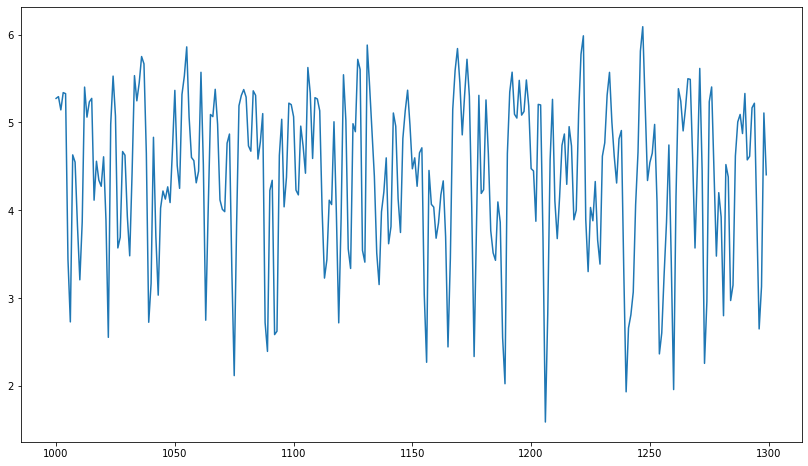

In [70]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(1000, 1300), sim[1000:1300])
plt.show()

In [71]:
TT = ppress_dfs[0]['norm']

In [100]:
import DAMP_V2
reload(DAMP_V2)
from DAMP_V2 import DAMP_V2

In [101]:
damp = DAMP_V2({"lookahead": 100, "enable_output": True})

In [102]:
scor, pos, left_MP = damp.DAMP_2_0(TT, 10, 100)

-----------------------------------------------
Thank you for using DAMP.
This is version 2.0 of DAMP, please email Eamonn Keogh (eamonn@cs.ucr.edu) or Yue Lu (ylu175@ucr.edu) to make sure you have the latest version.
This time series is of length 2888, and the subsequence length is 10
The lookahead modified from 100 to the next power of 2: 128.
Hints:
Usually, the subsequence length you should use is between about 50 to 90% of a typical period.
A good initial value of lookahead is about 2^nearest_power_of_two(16 times S).
The range of lookahead should be 0 to length(T)-location_to_start_processing.
If speed is important, you can tune lookahead to get greater speed-up in your domain.
A simple search, doubling and halving the current value,
 should let you quickly converge on a good value.
------------------------------------------


Results:
DAMP_V2 run time 0:00:22.819879
Pruning Rate: 0.7632241813602015
Predicted discord score/position: 2.8770769782652943 / [113]


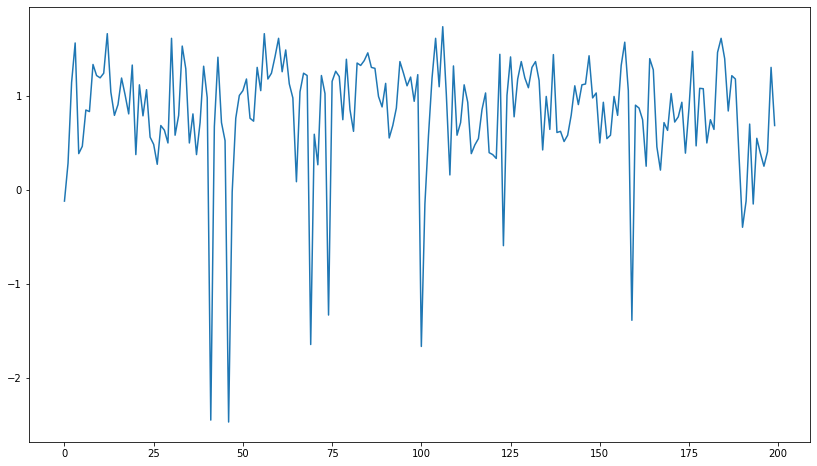

In [74]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(0, 200), TT[:200])
plt.show()

In [75]:
len(left_MP)

2888

In [76]:
max(left_MP)

2.877077078265294

In [82]:
max_mp = np.where(left_MP == max(left_MP))
print(max_mp[0])

[113]


In [83]:
left_MP[113]

2.877077078265294

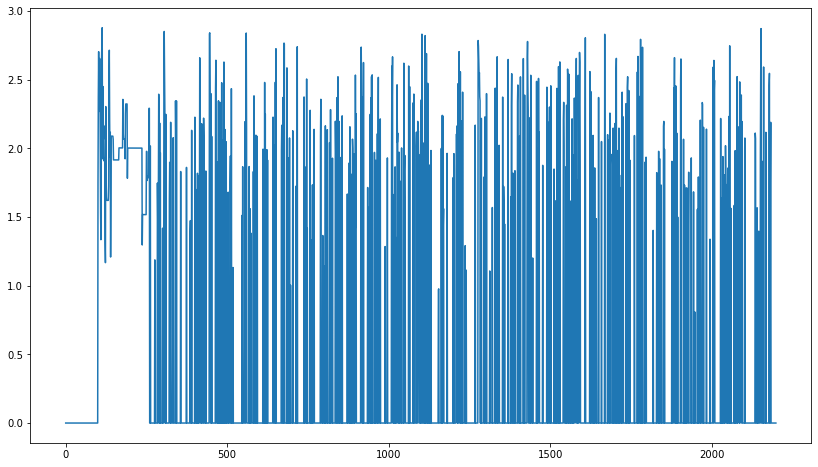

In [86]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(0, 2200), left_MP[:2200])
plt.show()

In [87]:
maxa = np.where(left_MP > 2.8)
print(maxa)

(array([ 113,  305,  445,  446,  559, 1103, 1113, 1609, 1669, 2153, 2388,
       2413, 2516, 2650], dtype=int64),)


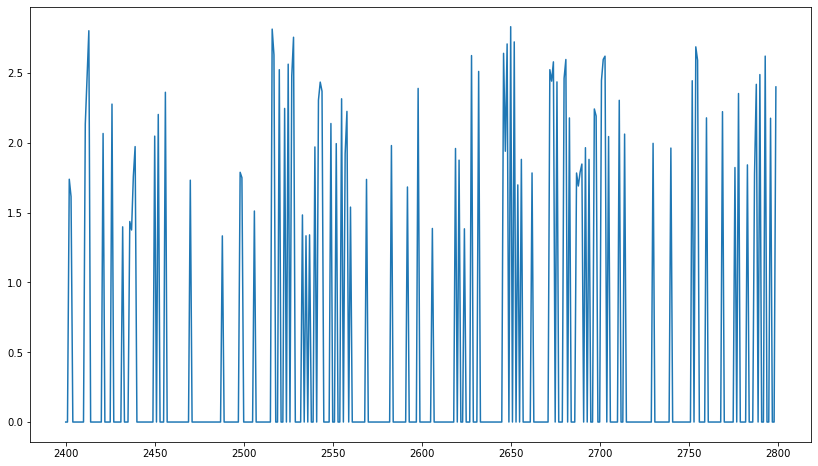

In [88]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(2400, 2800), left_MP[2400:2800])
plt.show()

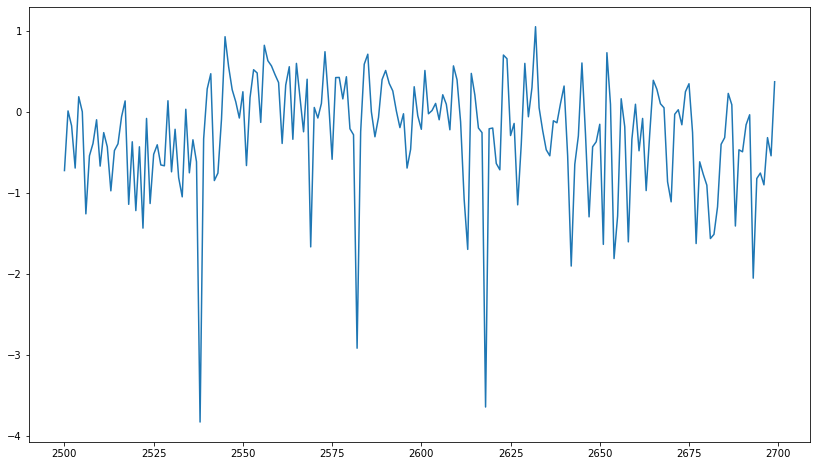

In [99]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(2500, 2700), TT[2500:2700])
plt.show()